In [4]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = openai.api_key = "XXXX" #use your openai api key here
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [6]:
def plot_preds2(train, test, pred_dict, model_name, show_samples=False,plot_median=False):
    pred_median = pred_dict['median']
    pred_median = pd.Series(pred_median, index=test.index)
    
    
    pred_mean = pred_dict['mean']
    pred_mean = pd.Series(pred_mean, index=test.index)
    
    mse_median = mean_squared_error(test, pred_median)
    mae_median =mean_absolute_error (test,pred_median)
    mse_mean = mean_squared_error(test, pred_mean)
    mae_mean = mean_absolute_error(test,pred_mean)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train, label='Train', color='blue')
    plt.plot(test, label='Truth', color='black')
    if plot_median:
        plt.plot(pred_median, label=f'Pred_Median (MSE: {mse_median:.2f}, MAE: {mae_median:.2f})', color='purple')
    plt.plot(pred_mean, label=f'Pred_Mean (MSE: {mse_mean:.2f}, MAE: {mae_mean:.2f})', color='red')

    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred_median.index, lower, upper, alpha=0.3, color='purple')
    
    if show_samples:
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred_median.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    
    plt.legend(loc='upper left')
    
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()
    

## Define models ##

In [7]:


arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

gpt_hypers = dict(
    temp=0.6,
    alpha=0.95,
    beta=0.7,
    basic=True,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt_hypers},
    
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
   
}

model_names = list(model_predict_fns.keys())

## Running LLMTime and Visualizing Results ##

In [8]:
datasets = get_datasets()
ds_name = "AirPassengersDataset"

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
print(f"Dataset: {ds_name}")
print(train.shape, test.shape)

Dataset: AirPassengersDataset
(115,) (29,)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.6, 'alpha': 0.95, 'beta': 0.7, 'basic': True, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

now is LSTP prompting


100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


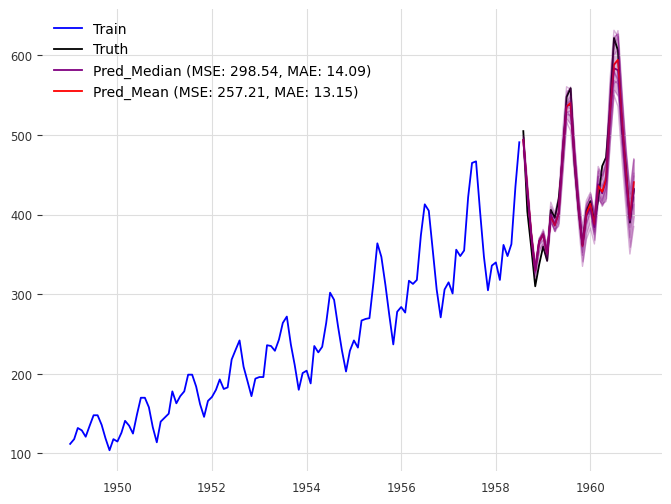

In [9]:
train=train[:]
all_time_steps=35
breath_steps=12
dataname="the monthly total number of AirPassengers" 
num_samples=10
prompt_method="LSTP"#LSTP or LLM-TIME 
#The LSTPrompt defaults to using GPT-4 and is based on preprocessing of llmtime.

for model in model_names: 
    model_hypers[model].update({'dataset_name': ds_name}) 
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = num_samples
    pred_dict = get_autotuned_predictions_data(train[:], test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False,prompt_method=prompt_method,all_time_steps=all_time_steps,breath_steps=breath_steps,dataname=dataname)
    means = {}
    samples = pred_dict['samples']
    for col in samples.columns:
        current_column = samples[col]
        
        std_dev = current_column.std()
        mean = current_column.mean()
        
        lower_bound = mean - 1.5 * std_dev
        upper_bound = mean + 1.5 * std_dev
        
        filtered_column = current_column[(current_column >= lower_bound) & (current_column <= upper_bound)]
        
        means[col] = filtered_column.mean()

    means_series = pd.Series(means)
    pred_dict['mean'] = means_series
    out[model] = pred_dict
    plot_preds2(train, test, pred_dict, model, show_samples=True,plot_median=True)

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.6, 'alpha': 0.95, 'beta': 0.7, 'basic': True, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

now is LLM-TIME prompting


100%|██████████| 1/1 [00:04<00:00,  4.49s/it]


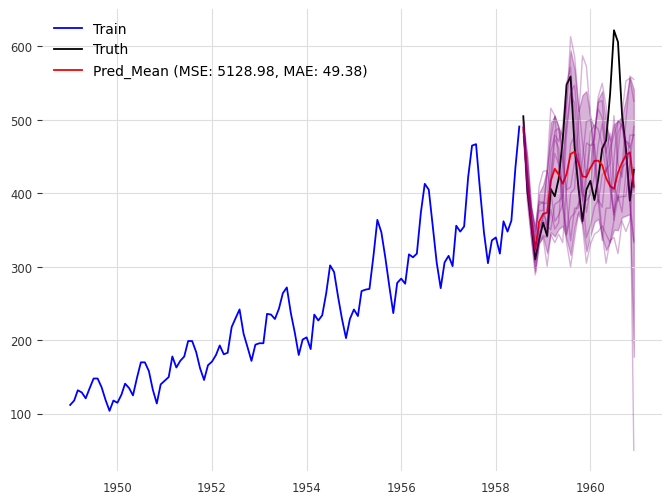

In [10]:
train=train[:]

num_samples=10
prompt_method="LLM-TIME"#LSTP or LLM-TIME 

for model in model_names:
    model_hypers[model].update({'dataset_name': ds_name}) 
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = num_samples
    pred_dict = get_autotuned_predictions_data(train[:], test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False,prompt_method=prompt_method,all_time_steps=all_time_steps,breath_steps=breath_steps,dataname=dataname)
    means = {}
    samples = pred_dict['samples']
    for col in samples.columns:    
        current_column = samples[col]
        means[col] = current_column.mean()

    means_series = pd.Series(means)
    pred_dict['mean'] = means_series
    out[model] = pred_dict
    plot_preds2(train, test, pred_dict, model, show_samples=True)